<a href="https://colab.research.google.com/github/MathewBiddle/ioos_by_the_numbers/blob/main/GTS_Totals_weather_act.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IOOS GTS Statistics

Created: 2020-10-10

Updated: 2022-07-26

The Global Telecommunication System (GTS) is a coordinated effort for rapid distribution of observations.
The GTS monthly reports show the number of messages released to GTS for each station.
The reports contain the following fields:

- location ID: Identifier that station messages are released under to the GTS;
- region: Designated IOOS Regional Association (only for IOOS regional report);
- sponsor: Organization that owns and maintains the station;
- Met: Total number of met messages released to the GTS
- Wave: Total number of wave messages released to the GTS

In this notebook we will explore the statistics of the messages IOOS is releasing to GTS.

## Using this notebook

1. Pick the appropriate date range of interest.
1. Edit the variables `start_date` and `end_date` in the cell below to reflect your time period of interest (use `YYYY-MM-DD` format).
1. Run all the cells in the notebook.

The first step is to pick the appropriate date range of interest.

In [189]:
start_date = "2018-01-01"
end_date = "2018-12-31"

Now we download the data. We will use the NDBC ioosstats server that [hosts the CSV files](https://www.ndbc.noaa.gov/ioosstats/) with the ingest data.

In [190]:
import datetime as dt

import pandas as pd

# example https://www.ndbc.noaa.gov/ioosstats/rpts/2021_03_ioos_regional.csv

start = dt.datetime.strptime(start_date, "%Y-%m-%d")
end = dt.datetime.strptime(end_date, "%Y-%m-%d")

# build an array for days between dates
date_array = (start + dt.timedelta(days=x) for x in range(0, (end - start).days))

# get a unique list of year-months for url build
months = []
for date_object in date_array:
    months.append(date_object.strftime("%Y-%m"))
months = sorted(set(months))

df_ioos = pd.DataFrame(columns=["locationID", "region", "sponsor", "met", "wave"])
df_ndbc = pd.DataFrame(columns=["locationID", "sponsor", "met", "wave"])
df_nonndbc = pd.DataFrame(columns=["locationID", "sponsor", "met", "wave"])
df_out = pd.DataFrame(columns=["locationID", "region", "sponsor", "met", "wave"])


for month in months:
    url_ioos = (
        "https://www.ndbc.noaa.gov/ioosstats/rpts/%s_ioos_regional.csv"
        % month.replace("-", "_")
    )
    df1 = pd.read_csv(url_ioos, dtype={"met": float, "wave": float})
    df1["time (UTC)"] = pd.to_datetime(month)
    df1['source'] = 'IOOS'
    df_ioos = pd.concat([df_ioos, df1])

    url_ndbc = ("https://www.ndbc.noaa.gov/ioosstats/rpts/%s_ndbc.csv" 
               % month.replace("-", "_")
               )
    df2 = pd.read_csv(url_ndbc, dtype={"met": float, "wave": float})
    df2["time (UTC)"] = pd.to_datetime(month)
    df2['source'] = 'NDBC'
    df_ndbc = pd.concat([df_ndbc, df2])

    url_nonndbc = ("https://www.ndbc.noaa.gov/ioosstats/rpts/%s_non_ndbc.csv" 
               % month.replace("-", "_")
               )
    df3 = pd.read_csv(url_nonndbc, dtype={"met": float, "wave": float})
    df3["time (UTC)"] = pd.to_datetime(month)
    df3['source'] = 'non-NDBC'
    df_nonndbc = pd.concat([df_nonndbc, df2])

    df_out = pd.concat([df_out, df1, df2, df3])

print(df_ioos.describe())

print(df_ndbc.describe())

print(df_nonndbc.describe())

print(df_out.describe())

                met         wave
count   2019.000000  2019.000000
mean    5076.863794   785.858346
std     5784.340214  1781.674655
min        0.000000     0.000000
25%        0.000000     0.000000
50%     2492.000000     0.000000
75%     8725.000000    72.000000
max    72852.000000  8866.000000
               met         wave
count  1769.000000  1769.000000
mean   3150.257773   838.563030
std    3198.312190   729.387125
min       0.000000     0.000000
25%    1424.000000     0.000000
50%    1480.000000  1330.000000
75%    5748.000000  1470.000000
max    8928.000000  2974.000000
               met         wave
count  1769.000000  1769.000000
mean   3150.257773   838.563030
std    3198.312190   729.387125
min       0.000000     0.000000
25%    1424.000000     0.000000
50%    1480.000000  1330.000000
75%    5748.000000  1470.000000
max    8928.000000  2974.000000
                met        wave
count   9900.000000  9900.00000
mean    6653.271313   540.41899
std     6118.236060  1266.33819

Let us check the monthly sum of data released both for individual met and wave and the totals.

In [191]:
import pandas as pd

df_out["time (UTC)"] = pd.to_datetime(df_out["time (UTC)"])

# Remove time-zone info for easier plotting, it is all UTC.
df_out["time (UTC)"] = df_out["time (UTC)"].dt.tz_localize(None)

groups = df_out.groupby(pd.Grouper(key="time (UTC)", freq="M"))

<ipython-input-192-e64b63e8754f>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groups.sum().plot(kind='bar')


<Axes: xlabel='time (UTC)'>

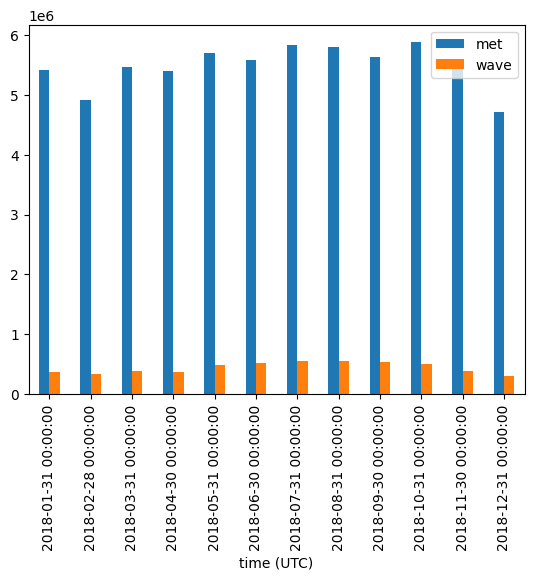

In [192]:
groups.sum().plot(kind='bar')

We can create a table of observations per month,

In [193]:
s = groups[
    [ "met", "wave"]
].sum()  # reducing the columns so the summary is digestable
totals = s.assign(total=s["met"] + s["wave"])
totals.index = totals.index.to_period("M")

print(f"Monthly totals:\n{totals}\n")

print(
    f"Sum for time period {totals.index.min()} to {totals.index.max()}: {totals['total'].sum()}"
)

Monthly totals:
                  met      wave      total
time (UTC)                                
2018-01     5416106.0  368948.0  5785054.0
2018-02     4906308.0  337780.0  5244088.0
2018-03     5454492.0  382206.0  5836698.0
2018-04     5388108.0  379066.0  5767174.0
2018-05     5696122.0  490110.0  6186232.0
2018-06     5585102.0  530452.0  6115554.0
2018-07     5821320.0  563128.0  6384448.0
2018-08     5797116.0  558352.0  6355468.0
2018-09     5636020.0  544408.0  6180428.0
2018-10     5872930.0  498252.0  6371182.0
2018-11     5580144.0  387384.0  5967528.0
2018-12     4713618.0  310062.0  5023680.0

Sum for time period 2018-01 to 2018-12: 71217534.0


and visualize it in a bar plot.

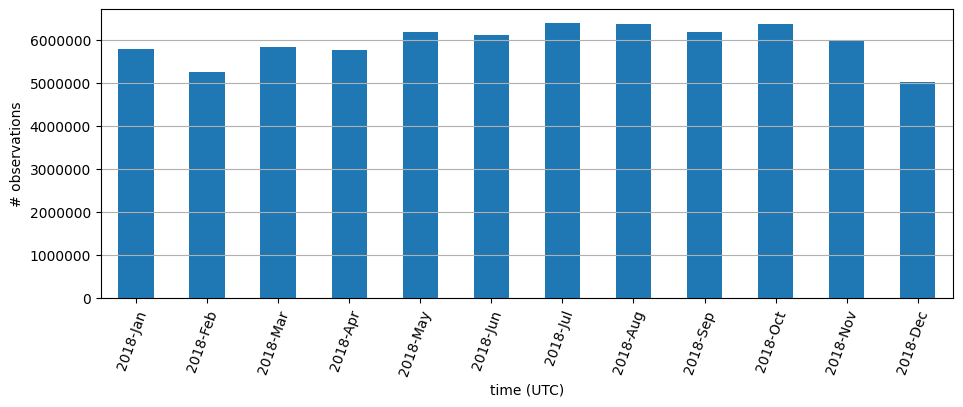

In [194]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 3.75))

totals['total'].plot(ax=ax, kind="bar",stacked=True)
ax.set_xticklabels(
    labels=s.index.to_series().dt.strftime("%Y-%b"),
    rotation=70,
    rotation_mode="anchor",
    ha="right",
)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_ylabel("# observations")
ax.grid(axis='y')

Group by source, then by month

In [195]:
group = df_out.groupby(by=['source', pd.Grouper(key="time (UTC)", freq="M")])


s = group[
    ["met", "wave"]
].sum()  # reducing the columns so the summary is digestable

totals = s.assign(total=s["met"] + s["wave"])

totals.reset_index(['source'], inplace=True)

totals.index = totals.index.to_period("M").strftime('%Y-%b')

totals
# bar_data = totals.reset_index()

# bar_data.loc[bar_data['sponsor']=='NATIONAL ESTUARINE RESEARCH RESERVE SYSTEM']

,source,met,wave,total
time (UTC),,,,
2018-Jan,IOOS,701780.0,63624.0,765404.0
2018-Feb,IOOS,676688.0,61886.0,738574.0
2018-Mar,IOOS,759916.0,69014.0,828930.0
2018-Apr,IOOS,773482.0,75758.0,849240.0
2018-May,IOOS,890444.0,155768.0,1046212.0
2018-Jun,IOOS,936078.0,199180.0,1135258.0
2018-Jul,IOOS,968256.0,219828.0,1188084.0
2018-Aug,IOOS,1005594.0,219026.0,1224620.0
2018-Sep,IOOS,982458.0,209388.0,1191846.0


# Create stacked bar chart

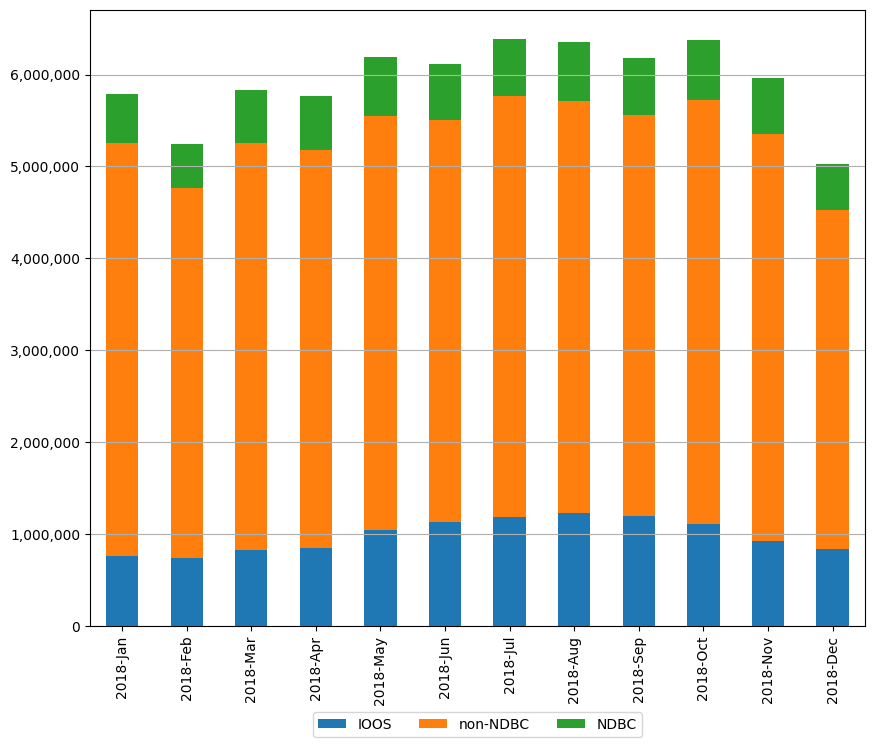

In [203]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator,
                               FuncFormatter)

fig, axs = plt.subplots(figsize=(10,8))

df_final = pd.DataFrame({'IOOS': totals.loc[totals['source']=='IOOS','total'],
                         'non-NDBC': totals.loc[totals['source']=='non-NDBC','total'],
                         'NDBC': totals.loc[totals['source']=='NDBC','total'],
                         },
                         index= totals.index.unique())

df_final.plot.bar(stacked=True, xlabel='', ax=axs, rot=90)

axs.legend(loc='center',bbox_to_anchor=(0.5,-0.16,0,0),ncol=3)

axs.grid(axis='y')

axs.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))